Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

In [71]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, kruskal, shapiro

from sklearn.preprocessing import OneHotEncoder as SklearOneHotEncoder
from statsmodels.regression.linear_model import OLS

import statsmodels.api as sa
import scikit_posthocs as sp 

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [72]:
df = pd.read_csv('churn.csv')

In [73]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

city – город

phone – основное устройство, которое использует водитель

signup_date – дата регистрации аккаунта (YYYYMMDD)

last_trip_date – дата последней поездки (YYYYMMDD)

avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации

avg_rating_by_driver – средняя оценка поездок водителем

avg_rating_of_driver – средняя оценка поездок водителя

surge_pct – процент поездок, совершенных с множителем > 1

avg_surge – средний множитель всплеска за все поездки этого водителя

trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после 
регистрации

luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
weekday_pct – процент поездок пользователя, совершенных в будние дни

______________________________________________________

* Посмотрите на данные и сформулируйте предположения, которые будете тестировать
* Создадайте лейбл churn/not_churn
* Постройте графики
* Выбирете гипотезу и подходящий тест для ее проверки
* Сформулируйте выводы и суммируйте всё что было

In [98]:
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
days_since_last_trip               int64
churn                             object
dtype: object

In [99]:
# Изменяем тип для дат:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
 12  days_since_last_trip    50000 non-null  int64 

In [77]:
df.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
std       19.958811                3.792684     37.081503  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000

In [78]:
df.describe(include='object')

city   phone
count        50000   49604
unique           3       2
top     Winterfell  iPhone
freq         23336   34582

In [79]:
df.describe(include='datetime')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



last_trip_date          signup_date
count                 50000                50000
unique                  182                   31
top     2014-06-29 00:00:00  2014-01-18 00:00:00
freq                   2036                 2948
first   2014-01-01 00:00:00  2014-01-01 00:00:00
last    2014-07-01 00:00:00  2014-01-31 00:00:00

In [80]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней 

In [81]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [101]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [102]:
# Преобразуем в int:

In [84]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [86]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

days_since_last_trip      churn
0                        14  not_churn
1                        57      churn
2                       175      churn
3                         2  not_churn
4                       108      churn
...                     ...        ...
49995                    26  not_churn
49996                   157      churn
49997                    40      churn
49998                   167      churn
49999                    72      churn

[50000 rows x 2 columns]

In [ ]:
# Видим, что очень много пользователей не использовали сервис в последнем месяце. 
# Нужно разобраться, какие факторы могут влиять на отток водителей

In [103]:
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

In [88]:
fig = px.histogram(df, x='churn')
fig.show()

Отразим на графике нормализованные значения (сравниваем не сырые числа):

In [89]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()


Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [90]:
pd.crosstab(df.churn, df.phone)

phone      Android  iPhone
churn                     
churn        11876   19057
not_churn     3146   15525

In [91]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn', 
                   color='phone')
fig.show()

Делать вывод только по графику – не очень хорошо, поэтому проверим гипотезу с помощью статистического теста.

Для проверки этой гипотезы я использую ХИ-КВАДРАТ, поскольку обе переменные категориальные.

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [104]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))
stat, p

(2558.394212267425, 0.0)

In [94]:
# Интерпретируем результат:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [95]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [105]:
# это качественные переменные, поэтому применяем хи квадрат
pd.crosstab(df.churn, df.city)

city       Astapor  King's Landing  Winterfell
churn                                         
churn        12306            3767       15123
not_churn     4228            6363        8213

In [106]:
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn', 
                   color='city')
fig.show()

In [43]:
# размер оттока в разных городах отличается:
# Отток водителей из Winterfell и Astapor больше, чем из King's Landing

Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

In [44]:
# сравниваем одну номинативную другую количественную переменную, 
# поэтому используем тест Шапиро-Уилка

In [97]:
dff = df[['city','trips_in_first_30_days']]
dff.head()

city  trips_in_first_30_days
0  King's Landing                       4
1         Astapor                       0
2         Astapor                       3
3  King's Landing                       9
4      Winterfell                      14

In [107]:
stat, p = scipy.stats.shapiro(df['trips_in_first_30_days'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.565, p-value=0.000
Отклонить гипотезу о нормальности


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



In [108]:
col_1 = df.query('city == "Astapor"').trips_in_first_30_days
col_2 = df.query('city == "King\'s Landing"').trips_in_first_30_days
col_3 = df.query('city == "Winterfell"').trips_in_first_30_days

In [65]:
# Распределения не являются нормальными, поэтому используем непараметрический аналог 
# ANOVA – критерий Краскела-Уоллиса

kruskal(col_1, col_2, col_3)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

In [66]:
# найдены статистически значимые различия pvalue>0.05, посмотрим на распределение по графику

In [67]:
churn = df[['churn', 'trips_in_first_30_days']]

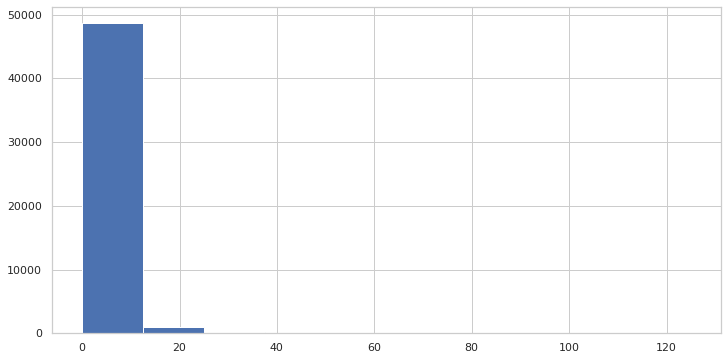

In [68]:
churn.trips_in_first_30_days.hist()

In [ ]:
# Распределение переменной trips_in_first_30_days не является нормальным, поэтому для проверки 
# гипотезы я использую U-КРИТЕРИЙ МАННА-УИТНИ

In [69]:
mannwhitneyu(churn.query('churn == "not_churn"').trips_in_first_30_days,
            churn.query('churn == "churn"').trips_in_first_30_days)
# P_value=0 - это стат значимое различие.

MannwhitneyuResult(statistic=351842132.0, pvalue=0.0)

In [109]:
gr_churn = churn.query('churn == "churn"').trips_in_first_30_days
gr_churn.mean()

1.6584818566482882

In [110]:
gr_not_churn = churn.query('churn == "not_churn"').trips_in_first_30_days
gr_not_churn.mean()

3.3063178047223993

In [ ]:
# Результат оказался статистически значим, значит, различия между группами есть 
# и ушедшие пользователи действительно были менее активными